# Outils de traitement de Corpus
Lucile BESSAC   n°21901117  M1 PluriTAL

Ce notebook détaille les étapes du projet de constitution / exploitation / évaluation d'un corpus.

Le corpus de référence est `katanaml-org/invoices-donut-data-v1` disponible ici `https://huggingface.co/datasets/katanaml-org/invoices-donut-data-v1` et l'objectif est de constituer un corpus similaire puis de l'évaluer.


In [23]:
import praw
import os
import glob
import requests

## Récupérer les données : le scrapping

Mon corpus de référence servant à fine-tuner le modèle de langue Donut qui est un transformer de compréhension de texte sans OCR, je devais récupérer des images contenant du texte ainsi que leur transcription.

J'ai donc choisi de scrapper le fil `r/tumblr` de reddit puisqu'y sont postées des images contenant du texte.

In [24]:
# Initialisation de praw (wrapper de l'API reddit)
reddit = praw.Reddit(client_id="14JBbvpP01tPby97id6m4w",
                    client_secret="5ayqREao03PQKDMmxGTLtCVgaP6OcA",
                    user_agent="klmpost")

In [25]:
# Subreddit à scrapper
subreddit_name = "tumblr"
data_path = "../Data/Raw/Images/"

def crea_dossier(data_path):
    """
    Crée le dossier de stockage des images spécifié s'il n'existe pas.

    Args:
        data_path (str): Le chemin du répertoire à créer.
    """
    if not os.path.exists(data_path):
        os.makedirs(data_path)

crea_dossier(data_path)

In [26]:
# Objet subreddit
subreddit = reddit.subreddit(subreddit_name)

def scrapping_subreddit(subreddit, data_path, limit=100):
    """
    Télécharge les images des posts récents d'un subreddit.

    Args:
        subreddit (praw.models.Subreddit): L'objet subreddit à scrapper.
        data_path (str): Le chemin où les images seront sauvegardées.
        limit (int): Le nombre de posts à analyser.
    """
    print("En train de scrapper le subreddit :", subreddit_name)

    # Pour chacun des X derniers posts
    for post in subreddit.new(limit=limit):
        # Si le post est une image
        if post.url.endswith(('.jpg', '.jpeg', '.png')):
            image_url = post.url
            # Récupère l'image
            image = requests.get(image_url).content
            # Sauvegarde l'image
            with open(os.path.join(data_path, f"{post.id}.jpg"), "wb") as f:
                f.write(image)
            print("Image du post", post.id, "enregistrée dans le fichier",post.id,".jpg")
    print("\n Images enregistrées dans le dossier :", data_path)

# Télécharger les images des posts récents du subreddit
scrapping_subreddit(subreddit, data_path)

En train de scrapper le subreddit : tumblr
Image du post 1cuppez enregistrée dans le fichier 1cuppez .jpg
Image du post 1cubaj5 enregistrée dans le fichier 1cubaj5 .jpg
Image du post 1cua1fn enregistrée dans le fichier 1cua1fn .jpg
Image du post 1cu5vlr enregistrée dans le fichier 1cu5vlr .jpg
Image du post 1cu1sah enregistrée dans le fichier 1cu1sah .jpg
Image du post 1ctwhxb enregistrée dans le fichier 1ctwhxb .jpg
Image du post 1ctusoc enregistrée dans le fichier 1ctusoc .jpg
Image du post 1ctotdh enregistrée dans le fichier 1ctotdh .jpg
Image du post 1ctjs8z enregistrée dans le fichier 1ctjs8z .jpg
Image du post 1cti4eh enregistrée dans le fichier 1cti4eh .jpg
Image du post 1ctdpbq enregistrée dans le fichier 1ctdpbq .jpg
Image du post 1ct32gu enregistrée dans le fichier 1ct32gu .jpg
Image du post 1cssauq enregistrée dans le fichier 1cssauq .jpg
Image du post 1cssa3j enregistrée dans le fichier 1cssa3j .jpg
Image du post 1cspq4m enregistrée dans le fichier 1cspq4m .jpg
Image du pos

## Rendre les données exploitables : l'OCR

Afin de récupérer le contenu textuel de mes images, et donc de rendre les données exploitables, j'ai choisi d'essayer d'utiliser l'OCR.

J'ai pour cela utilisé l'outil `pytesseract` de python.

In [27]:
from PIL import Image
import pytesseract
import pandas as pd

In [28]:
def ocr_images(data_path):
    """
    Extrait le texte des images dans un dossier en utilisant l'OCR.

    Args:
        data_path (str): Le chemin du dossier contenant les images.

    Returns:
        dict: Un dictionnaire avec les noms de fichiers d'images comme clés et le contenu extrait comme valeurs.
    """
    dico = {}

    for file_path in glob.glob(os.path.join(data_path, '*')):
        texte = pytesseract.image_to_string(Image.open(file_path))
        file_name = os.path.basename(file_path)
        dico[file_name] = { 'contenu' : [line for line in texte.split('\n')] }
    return dico

# Extraire le texte des images
dico = ocr_images(data_path)
print(dico)

KeyboardInterrupt: 

## Stocker les données : Parquet

J'ai fait le choix de stocker les données au format `.parquet` car c'est le format de stockage de mon corpus de référence. Il s'agit d'un format efficace pour stocker de grandes quantités de données.


In [29]:
folder_path = "../Data/Clean/"
parquet_path = "../Data/Clean/data.parquet"

def save_parquet(dico, folder_path, parquet_path):
    """
    Sauvegarde le dictionnaire contenant les résultats de l'OCR dans un fichier Parquet.

    Args:
        dico (dict): Le dictionnaire à sauvegarder.
        parquet_path (str): Le chemin du fichier Parquet.
    """

    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
    
    df = pd.DataFrame.from_dict(dico, orient='index')

    df.to_parquet(parquet_path, engine="pyarrow")

# Sauvegarder le dictionnaire dans un fichier Parquet
save_parquet(dico, folder_path, parquet_path)

## Charger les données dans python : Pandas dataframe

Afin de pouvoir accéder aux données dans python pour les explorer, j'ai choisi de passer par un `DataFrame` Pandas

In [30]:
def load_parquet(parquet_path):
    """
    Lit un fichier Parquet et retourne un DataFrame Pandas.

    Args:
        parquet_path (str): Le chemin du fichier Parquet.

    Returns:
        pd.DataFrame: Le DataFrame lu depuis le fichier Parquet.
    """
    return pd.read_parquet(parquet_path, engine="pyarrow")

# Lire le fichier Parquet
df = load_parquet(parquet_path)
print(df)

                                                       contenu
1ctjs8z.jpg  [r ] eldritchbauble Follow _, m Jani6, , You'r...
1ch543a.jpg  [f mymedlife Follow eee, , WARNING:, , Endosco...
1cln7bm.jpg  [Fi toddchavezwatchescartoons, ef Apr 18, 2024...
1cqk03b.jpg  [& junk-thunder Follow eee, AM, , "is sex with...
1ckz78p.jpg  [as danshive nes, Sep 16, 2023, | enjoy adding...
...                                                        ...
1cqrygv.jpg  [sunshinetheinspiration @ a reblogué, &@ theco...
1crt6gs.jpg  [<= hellsite-hall-of-fame, , £., , @ gayvian, ...
1ckxtsg.jpg  [BaZ celestial-fang Follow, Re. Mar 29, , 3 co...
1clqgwh.jpg  [coco6420 @ "Ss eee, , bro ur interupting my "...
1cm30l9.jpg  [radiofreederry Follow, , THERE'S NOTHING VY S...

[92 rows x 1 columns]


## Rendre les données exploitables : l'annotation

J'ai fait le choix de ne pas entreprendre l'annotation morpho-syntaxique de mes données car cela ne m'a pas semblé pertinent pour mon corpus.

## Statistiques de corpus

Afin d'évaluer la qualité des données récoltées, il est intéressant de faire des représentations visuelles des caractéristiques du corpus.

Cependant, mon corpus de référence ne contientt que 2 colonnes : l'image & le texte extrait de l'image. Il m'a donc été difficile de trouver des caractéristiques pertinentes à étudier.

J'ai tout de même choisi des caractéristiques que j'ai divisées en 2 catégories.

### Caractéristiques qualitatives

Dimension des images

Moyenne de longueur des transcriptions :
- En nb de lignes

-> Mon corpus

### Caractéristiques quantitatives

nb images et leur transcriptions
- Poids des images
- nb de tokens

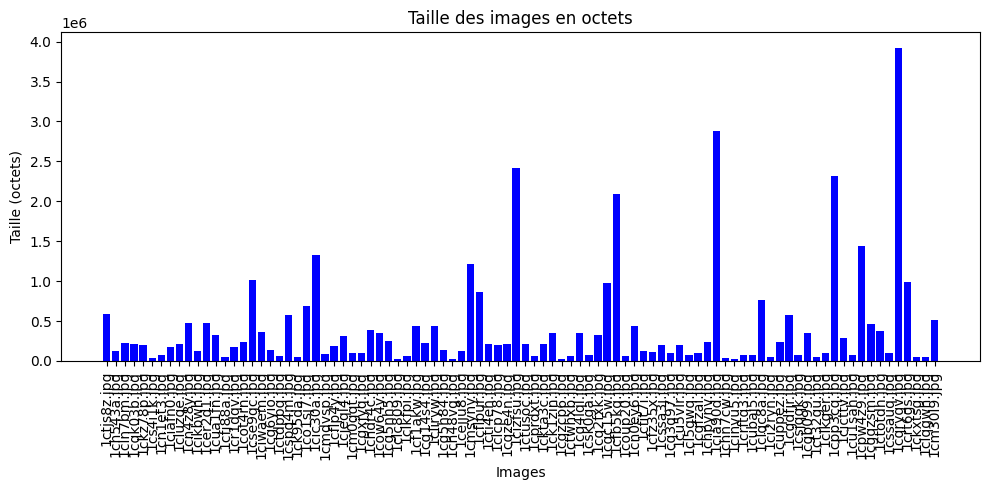

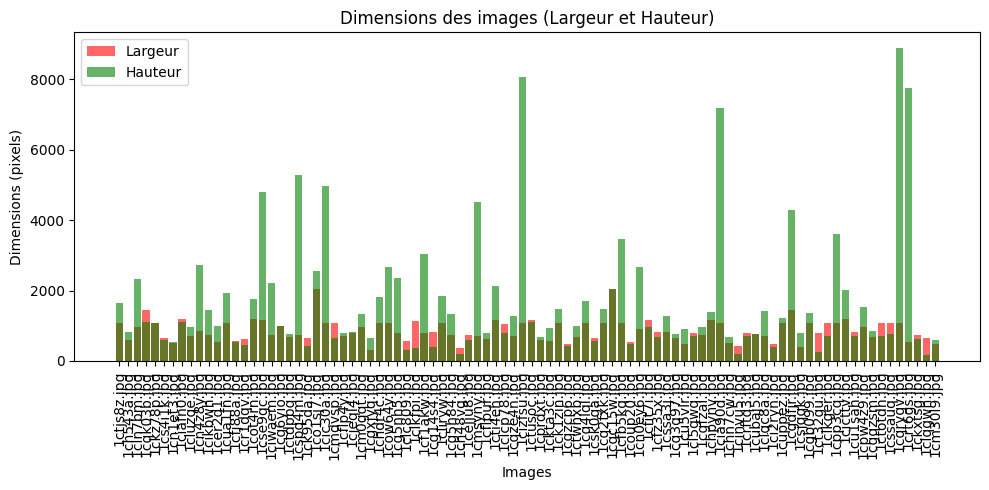

In [31]:
import os
import glob
import matplotlib.pyplot as plt

def get_image_info(file_path):
    """
    Affiche la taille et les dimensions d'une image.
    
    Args:
    file_path (str): Chemin vers le fichier image.
    
    Returns:
    tuple: Taille de l'image en octets, largeur et hauteur.
    """
    if os.path.exists(file_path):
        size = os.path.getsize(file_path)
        with Image.open(file_path) as img:
            width, height = img.size
        return size, width, height
    else:
        raise FileNotFoundError(f"Le fichier {file_path} n'existe pas.")

def collect_image_data(folder_path):
    """
    Collecte les informations de toutes les images dans un dossier.
    
    Args:
    folder_path (str): Chemin vers le dossier contenant les images.
    
    Returns:
    list: Liste de tuples contenant les informations des images.
    """
    image_data = []
    for file_path in glob.glob(os.path.join(folder_path, '*')):
        try:
            size, width, height = get_image_info(file_path)
            image_data.append((file_path, size, width, height))
        except FileNotFoundError as e:
            print(e)
    return image_data

def plot_image_data(image_data):
    """
    Génère des graphiques basés sur les informations des images.
    
    Args:
    image_data (list): Liste de tuples contenant les informations des images.
    """
    file_names = [os.path.basename(info[0]) for info in image_data]
    sizes = [info[1] for info in image_data]
    widths = [info[2] for info in image_data]
    heights = [info[3] for info in image_data]
    
    # Graphique des tailles d'images
    plt.figure(figsize=(10, 5))
    plt.bar(file_names, sizes, color='blue')
    plt.xlabel('Images')
    plt.ylabel('Taille (octets)')
    plt.title('Taille des images en octets')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

    # Graphique des dimensions d'images (largeur et hauteur)
    plt.figure(figsize=(10, 5))
    plt.bar(file_names, widths, color='red', alpha=0.6, label='Largeur')
    plt.bar(file_names, heights, color='green', alpha=0.6, label='Hauteur')
    plt.xlabel('Images')
    plt.ylabel('Dimensions (pixels)')
    plt.title('Dimensions des images (Largeur et Hauteur)')
    plt.xticks(rotation=90)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Chemin vers le dossier contenant les images
folder_path = '../Data/Raw/Images'

# Collecter les informations des images
image_data = collect_image_data(folder_path)

# Générer les graphiques basés sur les informations des images
plot_image_data(image_data)


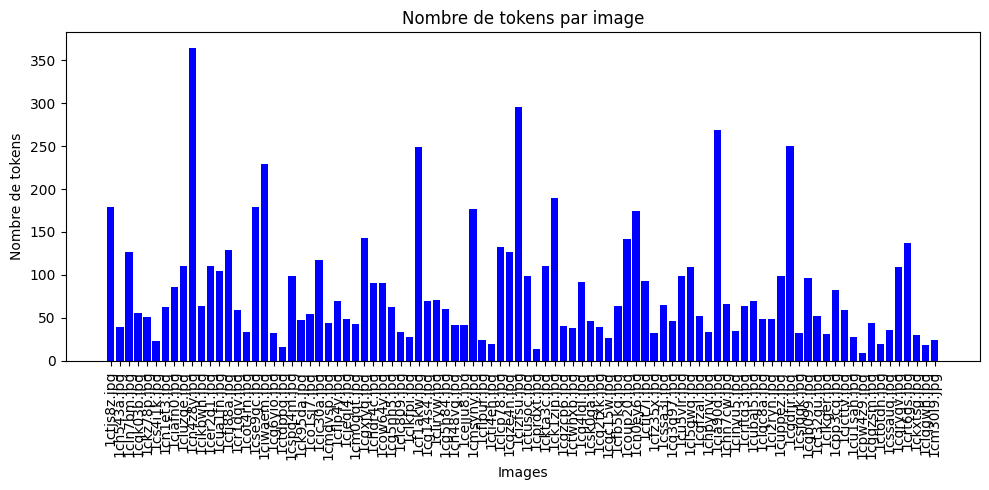

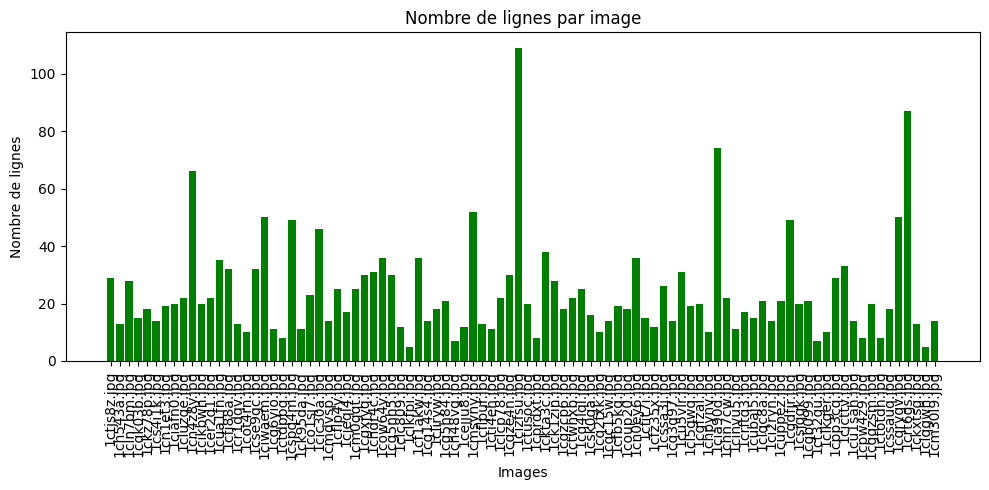

In [33]:

def generate_graphs(df):
    """
    Génère des graphiques montrant la longueur en nombre de tokens et la longueur en nombre d'éléments de la liste pour chaque élément du DataFrame.

    Args:
        df (pd.DataFrame): Le DataFrame contenant les données OCR.
    """
    # Calculer la longueur en nombre de tokens et en nombre d'éléments de la liste
    df['num_tokens'] = df['contenu'].apply(lambda x: sum(len(line.split()) for line in x))
    df['num_elements'] = df['contenu'].apply(len)

    # Générer le graphique pour la longueur en nombre de tokens
    plt.figure(figsize=(10, 5))
    plt.bar(df.index, df['num_tokens'], color='blue')
    plt.xlabel('Images')
    plt.ylabel('Nombre de tokens')
    plt.title('Nombre de tokens par image')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

    # Générer le graphique pour la longueur en nombre d'éléments de la liste
    plt.figure(figsize=(10, 5))
    plt.bar(df.index, df['num_elements'], color='green')
    plt.xlabel('Images')
    plt.ylabel('Nombre de lignes')
    plt.title('Nombre de lignes par image')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

# Générer les graphiques basés sur les informations des images
generate_graphs(df)


Cependant, 

Je ne pense pas qu'évaluer la longueur des textes (quantité de données) ou faire la liste des mots fréquents (qualité des données) soit par exemple pertinent.

Peut-être regarder la longueur des textes permettra de supprimer les images ne contenant pas de texte ?

Une autre option serait de comparer le ratio de compression image/transcription.

Les autres options de mesure de la qualité de l'OCR reposent sans surprise sur 

Regarder dans les papiers de mesure de qualité de l'OCR.

Visualiser les statistiques de son corpus (longueur des textes / mots fréquents (zipf) / statistiques adaptées à notre tâche)

## Visualiser les données


🧼Nettoyer son corpus🧼
📏Métriques d'évaluation📏


    Mesurer la correlation entre deux variables de votre corpus (ex. longueur des textes/longueur des résumés) a. Comment augmenter la p-value si elle n'est pas significative ?

    Eliminer les données abérrantes

    Augmenter ses données

    Splitter son corpus en test et train

    Evaluer son corpus avec les métriques adaptées

    Proposer une métrique pour son corpus autre que les métriques de la tâche



     

N'oubliez pas pour l'évaluation de votre repo, je vais surtout regarder si vous vous en êtes tenus aux points bonnes pratiques

    une bonne organisation de votre répertoire de travail
    les commit conventionnels
    les docstrings
    les conventions de nommage




    Le projet à rendre comprend:
        l'analyse d'un corpus pré-existant
        la constitution d'un corpus similaire à partir de données ouverte
        l'applications de visualisation sur ces données
        l'évaluation du corpus constitué

❗ Nous n'allons pas faire de Machine Learning sur le corpus ❗